In [ ]:
!pip install torch_geometric

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric torch-geometric-temporal -f https://data.pyg.org/whl/torch-1.11.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 42.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylin

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
# from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal

# Replace this line in /usr/local/lib/python3.10/dist-packages/torch_geometric_temporal/nn/attention/tsagcn.py
from torch_geometric.utils import to_dense_adj

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda


# Dataset

In [ ]:
num_nodes = 501
num_outputs = 7
eval_tickers = ["KO", "AAPL", "BAC", "XOM", "JPM", "BA", "DIS"]

# num_outputs = 9
# eval_tickers = ["AMD", "MMM", "MSFT", "CME", "ABT", "CL", "CVS", "F", "IBM"]

TICKERS = ['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE',
           'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD',
           'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE',
           'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY',
           'BDX', 'BEN', 'BG', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BWA',
           'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE',
           'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI',
           'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP',
           'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DAY', 'DD', 'DE', 'DFS', 'DG',
           'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOV', 'DOW', 'DPZ', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXCM', 'EA',
           'EBAY', 'ECL', 'ED', 'EFX', 'EG', 'EIX', 'EL', 'ELV', 'EMN', 'EMR', 'ENPH', 'EOG', 'EPAM', 'EQIX', 'EQR', 'EQT',
           'ES', 'ESS', 'ETN', 'ETR', 'ETSY', 'EVRG', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST', 'FCX', 'FDS',
           'FDX', 'FE', 'FFIV', 'FI', 'FICO', 'FIS', 'FITB', 'FLT', 'FMC', 'FOX', 'FOXA', 'FRT', 'FSLR', 'FTNT', 'FTV', 'GD',
           'GE', 'GEHC', 'GEN', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GNRC', 'GOOG', 'GOOGL', 'GPC', 'GPN', 'GRMN', 'GS', 'GWW',
           'HAL', 'HAS', 'HBAN', 'HCA', 'HD', 'HES', 'HIG', 'HII', 'HLT', 'HOLX', 'HON', 'HPE', 'HPQ', 'HRL', 'HSIC', 'HST',
           'HSY', 'HUBB', 'HUM', 'HWM', 'IBM', 'ICE', 'IDXX', 'IEX', 'IFF', 'ILMN', 'INCY', 'INTC', 'INTU', 'INVH', 'IP',
           'IPG', 'IQV', 'IR', 'IRM', 'ISRG', 'IT', 'ITW', 'IVZ', 'J', 'JBHT', 'JBL', 'JCI', 'JKHY', 'JNJ', 'JNPR', 'JPM',
           'K', 'KDP', 'KEY', 'KEYS', 'KHC', 'KIM', 'KLAC', 'KMB', 'KMI', 'KMX', 'KO', 'KR', 'KVUE', 'L', 'LDOS', 'LEN',
           'LH', 'LHX', 'LIN', 'LKQ', 'LLY', 'LMT', 'LNT', 'LOW', 'LRCX', 'LULU', 'LUV', 'LVS', 'LW', 'LYB', 'LYV', 'MA',
           'MAA', 'MAR', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT', 'MET', 'META', 'MGM', 'MHK', 'MKC', 'MKTX',
           'MLM', 'MMC', 'MMM', 'MNST', 'MO', 'MOH', 'MOS', 'MPC', 'MPWR', 'MRK', 'MRNA', 'MRO', 'MS', 'MSCI', 'MSFT',
           'MSI', 'MTB', 'MTCH', 'MTD', 'MU', 'NCLH', 'NDAQ', 'NDSN', 'NEE', 'NEM', 'NFLX', 'NI', 'NKE', 'NOC', 'NOW', 'NRG',
           'NSC', 'NTAP', 'NTRS', 'NUE', 'NVDA', 'NVR', 'NWS', 'NWSA', 'NXPI', 'O', 'ODFL', 'OKE', 'OMC', 'ON', 'ORCL',
           'ORLY', 'OTIS', 'OXY', 'PANW', 'PARA', 'PAYC', 'PAYX', 'PCAR', 'PCG', 'PEAK', 'PEG', 'PEP', 'PFE', 'PFG', 'PG',
           'PGR', 'PH', 'PHM', 'PKG', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PODD', 'POOL', 'PPG', 'PPL', 'PRU', 'PSA', 'PSX',
           'PTC', 'PWR', 'PXD', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'REG', 'REGN', 'RF', 'RHI', 'RJF', 'RL', 'RMD', 'ROK', 'ROL',
           'ROP', 'ROST', 'RSG', 'RTX', 'RVTY', 'SBAC', 'SBUX', 'SCHW', 'SHW', 'SJM', 'SLB', 'SNA', 'SNPS', 'SO', 'SPG',
           'SPGI', 'SRE', 'STE', 'STLD', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYF', 'SYK', 'SYY', 'T', 'TAP', 'TDG', 'TDY',
           'TECH', 'TEL', 'TER', 'TFC', 'TFX', 'TGT', 'TJX', 'TMO', 'TMUS', 'TPR', 'TRGP', 'TRMB', 'TROW', 'TRV', 'TSCO',
           'TSLA', 'TSN', 'TT', 'TTWO', 'TXN', 'TXT', 'TYL', 'UAL', 'UBER', 'UDR', 'UHS', 'ULTA', 'UNH', 'UNP', 'UPS', 'URI',
           'USB', 'V', 'VFC', 'VICI', 'VLO', 'VLTO', 'VMC', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'VTRS', 'VZ', 'WAB', 'WAT', 'WBA',
           'WBD', 'WDC', 'WEC', 'WELL', 'WFC', 'WHR', 'WM', 'WMB', 'WMT', 'WRB', 'WRK', 'WST', 'WTW', 'WY', 'WYNN', 'XEL', 'XOM',
           'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS']

In [ ]:
def get_zscores(period):
  df = pd.read_csv(f"/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/all_zscores_period={period}.csv")
  df = df.drop("Date", axis=1)
  df.reindex()

  return df

def get_edge_matrix(mode="precision"):
  modes = ["correlation", "dtw", "precision"]

  if mode not in modes:
      print("Invalid mode")
      return None

  edge_matrix = np.loadtxt(open(f"/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/{mode}_matrix.csv", "rb"), delimiter=",")

  return edge_matrix

def get_edge_dict(mode="precision", std=1):
  edge_matrix = get_edge_matrix(mode)
  n, m = edge_matrix.shape

  if mode == "correlation":
    # Assume most correlation are positive, which is true for this case
    threshold = [edge_matrix.mean() + std * edge_matrix.std(), None]
  elif mode == "dtw":
    threshold = [None, edge_matrix.mean() - std * edge_matrix.std()]
  elif mode == "precision":
    threshold = [edge_matrix.mean() + std * edge_matrix.std(), edge_matrix.mean() - std * edge_matrix.std()]
  else:
    threshold = 0


  edge_indices = [[], []]
  edge_weights = []

  for i in range(n):
      for j in range(i, m):
        if i == j:
          continue

        weight = edge_matrix[i][j]

        if mode == "correlation":
            if abs(weight) < threshold[0]:
              continue
        elif mode == "dtw":
            if weight > threshold[1]:
              continue
        elif mode == "precision":
            if weight < threshold[0] and weight > threshold[1]:
              continue

        # Undirected edge
        edge_indices[0].append(i)
        edge_indices[1].append(j)
        edge_weights.append(weight)

        edge_indices[0].append(j)
        edge_indices[1].append(i)
        edge_weights.append(weight)

  return np.array(edge_indices), np.array(edge_weights)

def get_all_nodes(period=1, window=10):
  # Node embeddings across all time
  df = get_zscores(period)
  # print(df.head())
  features = np.zeros((df.shape[0]-window, num_nodes, window))

  for i in range(window-1, df.shape[0]-1):
    tmp = df.loc[i-window+1:i].to_numpy()
    features[i-window+1] = tmp.T

  return features

def get_all_outputs(bin=True, period=1, window=10):
  df = get_zscores(period)
  output = np.zeros((df.shape[0]-window, num_outputs))
  tmp_tickers = [ f"{t}_log_returns_zscore" for t in eval_tickers ]

  for i in range(window, df.shape[0]):
    if bin:
      output[i-window] = df.loc[i-1][tmp_tickers] < df.loc[i][tmp_tickers]
    else:
      output[i-window] = df.loc[i][tmp_tickers]

  return output

In [ ]:
out = get_all_outputs(period=20, window=3)

out.shape

(298, 9)

In [ ]:
def build_graph_dataset(bin=True, edge_mode="precision", period=1, window=10, mul=1):
  edge_indices, edge_weights = get_edge_dict(mode=edge_mode, std=mul)
  all_outputs = get_all_outputs(bin=bin, period=period, window=window)
  all_nodes = get_all_nodes(period=period, window=window)

  dataset = StaticGraphTemporalSignal(edge_index=edge_indices, edge_weight=edge_weights,
                                       features=all_nodes, targets=all_outputs)

  return dataset

# Start

In [ ]:
edge_mode = "precision"
period = 20
window = 3
mul = 1
self_edge = 1

dataset = build_graph_dataset(edge_mode=edge_mode, period=period, window=window, mul=mul)

dataset[0]

Data(x=[501, 3], edge_index=[2, 17226], edge_attr=[17226], y=[9])

In [ ]:
adj_matrix = np.zeros((num_nodes, num_nodes))
edge_indices, _ = get_edge_dict(mode=edge_mode, std=mul)

for i in range(edge_indices.shape[1]):
  adj_matrix[edge_indices[0, i]][edge_indices[1, i]] = 1

for j in range(num_nodes):
  adj_matrix[j][j] = self_edge

# adj_matrix = adj_matrix.astype(int)
adj_matrix = torch.from_numpy(adj_matrix).to(device)

adj_matrix.sum(), edge_indices.shape[1], adj_matrix.dtype

(tensor(17727., device='cuda:0', dtype=torch.float64), 17226, torch.float64)

# Model

### Base GNN layer

In [ ]:
# Base GNN
class GNN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, normalize=True):
    super(GNN, self).__init__()
    self.convs = torch.nn.ModuleList()
    self.convs.append(GCNConv(in_channels, hidden_channels, normalize))
    self.convs.append(GCNConv(hidden_channels, hidden_channels, normalize))
    self.convs.append(GCNConv(hidden_channels, out_channels, normalize))

  def forward(self, x, edge_index, edge_weight=None):
    tmp_weight = edge_weight

    if tmp_weight is not None:
      tmp_weight = tmp_weight.abs()
      tmp_weight -= tmp_weight.min()
      tmp_weight /= tmp_weight.max()

    for step in range(len(self.convs)):
      x = F.relu(self.convs[step](x=x, edge_index=edge_index, edge_weight=tmp_weight))
    return x


class Double_GNN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, normalize=True):
    super(Double_GNN, self).__init__()
    self.convs = torch.nn.ModuleList()
    self.convs.append(GCNConv(in_channels, hidden_channels, normalize))
    self.convs.append(GCNConv(hidden_channels, out_channels, normalize))

  def forward(self, x, edge_index, edge_weight=None):
    for step in range(len(self.convs)):
      x = F.relu(self.convs[step](x, edge_index, edge_weight))
    return x


class Single_GNN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, normalize=True):
    super(Single_GNN, self).__init__()
    self.convs = torch.nn.ModuleList()
    self.convs.append(GCNConv(in_channels, out_channels, normalize))

  def forward(self, x, edge_index, edge_weight=None):
    for step in range(len(self.convs)):
      x = F.relu(self.convs[step](x, edge_index, edge_weight))
    return x

### Custom market cap rank pool

In [ ]:
# CapPool

import json

s_cap_rank_51 = np.zeros((num_nodes, 51))
s_cap_rank_11 = np.zeros((51, 11))

f = open("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/market_cap.json")
cap_dict = json.load(f)
cap_dict = sorted(cap_dict.items(), key=lambda x:x[1])

df_1 = pd.DataFrame(data=s_cap_rank_51.T, columns=TICKERS)

i = 0
for company in cap_dict:
  df_1[company[0]].loc[i//10] = 1 # i
  i += 1

s_cap_rank_51 = df_1.to_numpy().T

for j in range(51):
  k = j // 5
  s_cap_rank_11[j][k] = 1 # k

p_1 = torch.from_numpy(s_cap_rank_51).to(device)
p_2 = torch.from_numpy(s_cap_rank_11).to(device)

In [ ]:
# # Stock Pool
# df = pd.read_csv("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/stock_pool_s1.csv", sep=",", header=None)
# p_1 = df.values
# p_1 = torch.from_numpy(p_1).to(device)

# df = pd.read_csv("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/stock_pool_s2.csv", sep=",", header=None)
# p_2 = df.values
# p_2 = torch.from_numpy(p_2).to(device)


In [ ]:
def tech_pool(x, adj, s, mask=None):
  x = x.unsqueeze(0) if x.dim() == 2 else x
  adj = adj.unsqueeze(0) if adj.dim() == 2 else adj
  s = s.unsqueeze(0) if s.dim() == 2 else s

  batch_size, num_nodes, _ = x.size()
  s = torch.softmax(s, dim=-1)  # obtain matrix S, i.e. the assignment matrix

  if mask is not None:
    mask = mask.view(batch_size, num_nodes, 1).to(x.dtype)
    x, s = x * mask, s * mask

  # Output feature matrix
  out = torch.matmul(s.transpose(1, 2).float(), x.float())

  # Output adjacency matrix
  out_adj = torch.matmul(torch.matmul(s.transpose(1, 2), adj), s)

  # Filter out connections with strength below threshold (1 std above mean)
  out_adj = out_adj.where(out_adj < out_adj.mean() + out_adj.std(), 0)

  return out[0], out_adj[0], None, None


class TechPool(torch.nn.Module):
  def __init__(self, hidden_nodes, num_features, num_nodes, p_1, p_2):
    super(TechPool, self).__init__()

    self.p_1 = p_1
    self.p_2 = p_2

    # define pooling layer 1
    self.gnn1_embed = GNN(num_features, hidden_nodes, hidden_nodes)

    # define pooling layer 2
    self.gnn2_embed = GNN(hidden_nodes, hidden_nodes, hidden_nodes)

    # define pooling layer 3
    self.gnn3_embed = GNN(hidden_nodes, hidden_nodes, hidden_nodes)

    # define linear layers
    self.linear_layers = nn.Sequential(
        nn.Dropout(),
        torch.nn.Linear(hidden_nodes, num_nodes * 2),
        nn.ReLU(),
        torch.nn.Linear(num_nodes * 2, num_outputs)
    )

    # define sigmoid function for binary classification
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x, edge_index, edge_weight, adj, mask=None):
    # apply pooling layer 1
    x = self.gnn1_embed(x, edge_index, edge_weight=mask)
    x, adj, _, _ = tech_pool(x, adj, self.p_1, mask)
    edge_index = adj.nonzero().t().contiguous()

    # apply pooling layer 2
    x = self.gnn2_embed(x, edge_index, mask)
    x, adj, _, _ = tech_pool(x, adj, self.p_2, mask)
    edge_index = adj.nonzero().t().contiguous()

    # apply final convolution
    x = self.gnn3_embed(x, edge_index, mask)

    # apply linear function (leave for regression, otherwise add softmax)
    x = x.mean(dim=0)
    x = self.linear_layers(x)

    # return x # for regression
    return self.sigmoid(x)  # for binary classification

### Encoder decoder with custom pool

In [ ]:
# class EncoderDecoder(torch.nn.Module):
#   def __init__(self, hidden_nodes, num_features, num_nodes, p_1, p_2):
#     super(EncoderDecoder, self).__init__()

#     self.p_1 = p_1
#     self.p_2 = p_2

#     self.q_1 = torch.transpose(p_1, 0, 1)
#     self.q_2 = torch.transpose(p_2, 0, 1)

#     self.gnn1_embed = Single_GNN(num_features, hidden_nodes, hidden_nodes)

#     self.gnn2_embed = Single_GNN(hidden_nodes, hidden_nodes, hidden_nodes)

#     self.gnn3_embed = Single_GNN(hidden_nodes, hidden_nodes, hidden_nodes)

#     self.gnn4_embed = Single_GNN(hidden_nodes, hidden_nodes, hidden_nodes)

#     self.gnn5_embed = Single_GNN(hidden_nodes, hidden_nodes, hidden_nodes)

#     # define linear layers
#     self.linear_layers = nn.Sequential(
#         nn.Dropout(),
#         torch.nn.Linear(hidden_nodes, num_nodes * 2),
#         nn.ReLU(),
#         torch.nn.Linear(num_nodes * 2, num_outputs)
#     )

#     # define sigmoid function for binary classification
#     self.sigmoid = torch.nn.Sigmoid()

#   def forward(self, x, edge_index, edge_weight, adj, mask=None):

#     x = self.gnn1_embed(x, edge_index, mask)

#     # skip connection 1
#     x_1 = x
#     e_1 = edge_index

#     # apply pooling layer 1
#     x, adj, _, _ = tech_pool(x, adj, self.p_1, mask)
#     edge_index = adj.nonzero().t().contiguous()


#     x = self.gnn2_embed(x, edge_index, mask)
#     # skip connection 2
#     x_2 = x
#     e_2 = edge_index

#     # apply pooling layer 2
#     x, adj, _, _ = tech_pool(x, adj, self.p_2, mask)
#     edge_index = adj.nonzero().t().contiguous()

#     x = self.gnn3_embed(x, edge_index, mask)

#     # apply unpooling layer 2
#     x, adj, _, _ = tech_pool(x, adj, self.q_2, mask)
#     # edge_index = adj.nonzero().t().contiguous()

#     # skip connection 2
#     x = x + x_2
#     edge_index = e_2

#     x = self.gnn4_embed(x, edge_index, mask)

#     # apply unpooling layer 1
#     x, adj, _, _ = tech_pool(x, adj, self.q_1, mask)
#     # edge_index = adj.nonzero().t().contiguous()

#     # skip connection 1
#     x = x + x_1
#     edge_index = e_1

#     # final layer
#     x = self.gnn5_embed(x, edge_index, mask)

#     # apply linear function (leave for regression, otherwise add softmax)
#     x = x.mean(dim=0)
#     x = self.linear_layers(x)

#     # return x # for regression
#     return self.sigmoid(x)  # for binary classification

In [ ]:
class EncoderDecoder_2(torch.nn.Module):
  def __init__(self, hidden_nodes, num_features, num_nodes, p_1, p_2):
    super(EncoderDecoder_2, self).__init__()

    self.p_1 = p_1

    self.q_1 = torch.transpose(p_1, 0, 1)

    self.gnn1_embed = GNN(num_features, hidden_nodes, hidden_nodes)

    self.gnn2_embed = GNN(hidden_nodes, hidden_nodes, hidden_nodes)

    self.gnn3_embed = GNN(hidden_nodes, hidden_nodes, hidden_nodes)

    # define linear layers
    self.linear_layers = nn.Sequential(
        nn.Dropout(),
        torch.nn.Linear(hidden_nodes, num_nodes * 2),
        nn.ReLU(),
        torch.nn.Linear(num_nodes * 2, num_outputs)
    )

    # define sigmoid function for binary classification
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x, edge_index, edge_weight, adj, mask=None):

    x = self.gnn1_embed(x, edge_index, mask)

    # skip connection 1
    x_1 = x
    e_1 = edge_index

    # apply pooling layer 1
    x, adj, _, _ = tech_pool(x, adj, self.p_1, mask)
    edge_index = adj.nonzero().t().contiguous()

    x = self.gnn2_embed(x, edge_index, mask)

    # apply unpooling layer 1
    x, adj, _, _ = tech_pool(x, adj, self.q_1, mask)
    # edge_index = adj.nonzero().t().contiguous()

    # skip connection 1
    x = x + x_1
    edge_index = e_1

    # final layer
    x = self.gnn3_embed(x, edge_index, mask)

    # apply linear function (leave for regression, otherwise add softmax)
    x = x.mean(dim=0)
    x = self.linear_layers(x)


    # return x # for regression
    return self.sigmoid(x)  # for binary classification

### General GNN with pooling

In [ ]:
from torch_geometric.nn import GraphConv, TopKPooling, SAGPooling
from torch_geometric.nn import knn_graph


class GNNPool(torch.nn.Module):
  def __init__(self, hidden_nodes, num_features, num_nodes):
    super(GNNPool, self).__init__()

    # define pooling layer 1
    self.gnn1_embed = GNN(num_features, hidden_nodes, hidden_nodes)
    # self.pool1 = TopKPooling(32, ratio=0.8)
    # self.pool1 = SAGPooling(32, 0.8)

    # define pooling layer 2
    self.gnn2_embed = GNN(hidden_nodes, hidden_nodes, hidden_nodes)
    # self.pool2 = TopKPooling(32, ratio=0.8)
    # self.pool2 = SAGPooling(32, 0.8)

    # define pooling layer 3
    self.gnn3_embed = GNN(hidden_nodes, hidden_nodes, hidden_nodes)

    # define linear layers
    self.linear_layers = nn.Sequential(
        nn.Dropout(),
        torch.nn.Linear(hidden_nodes, num_nodes * 2),
        nn.ReLU(),
        torch.nn.Linear(num_nodes * 2, num_outputs)
    )

    # define sigmoid function for binary classification
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x, edge_index, edge_weight, adj, mask=None):
    # apply pooling layer 1
    x = self.gnn1_embed(x, edge_index, mask)
    # x, edge_index, _, _, _, _ = self.pool1(x, edge_index)
    # edge_index = knn_graph(x, k=2)

    # apply pooling layer 2
    x = self.gnn2_embed(x, edge_index, mask)
    # x, edge_index, _, _, _, _ = self.pool2(x, edge_index)
    # edge_index = knn_graph(x, k=2)

    # apply final convolution
    x = self.gnn3_embed(x, edge_index, mask)

    # apply linear function (leave for regression, otherwise add softmax)
    x = x.mean(dim=0)
    x = self.linear_layers(x)

    # return x # for regression
    return self.sigmoid(x)  # for binary classification

### Diff Pool

In [ ]:
from torch_geometric.nn import dense_diff_pool
import math


class DiffPool(torch.nn.Module):
  def __init__(self, hidden_nodes, num_features, num_nodes):
    super(DiffPool, self).__init__()

    pool_num_nodes = math.ceil(0.25 * num_nodes)
    # define pooling layer 1
    self.gnn1_pool = GNN(num_features, hidden_nodes, pool_num_nodes)
    self.gnn1_embed = GNN(num_features, hidden_nodes, hidden_nodes)

    pool_num_nodes = math.ceil(0.25 * pool_num_nodes)
    # define pooling layer 2
    self.gnn2_pool = GNN(hidden_nodes, hidden_nodes, pool_num_nodes)
    self.gnn2_embed = GNN(hidden_nodes, hidden_nodes, hidden_nodes)

    # define pooling layer 3
    self.gnn3_embed = GNN(hidden_nodes, hidden_nodes, hidden_nodes)

    # define linear layers
    self.linear_layers = nn.Sequential(
        nn.Dropout(),
        torch.nn.Linear(hidden_nodes, num_nodes * 2),
        nn.ReLU(),
        torch.nn.Linear(num_nodes * 2, num_outputs)
    )

    # define sigmoid function for binary classification
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x, edge_index, edge_weight, adj, mask=None):
    adj = adj.to(torch.float)
    print("Check 1")
    # apply pooling layer 1
    s = self.gnn1_pool(x, edge_index, mask)
    x = self.gnn1_embed(x, edge_index, mask)
    x, adj, _, _ = dense_diff_pool(x, adj, s)
    print("Check 2")
    # apply pooling layer 2
    s = self.gnn2_pool(x, edge_index, mask)
    x = self.gnn2_embed(x, edge_index, mask)
    x, adj, _, _ = dense_diff_pool(x, adj, s)
    print("Check 3")
    # apply final convolution
    x = self.gnn3_embed(x, edge_index, mask)
    print("Check 4")
    # apply linear function (leave for regression, otherwise add softmax)
    x = x.mean(dim=0)
    x = self.linear_layers(x)
    print("Check 5")
    # return x # for regression
    return self.sigmoid(x)  # for binary classification

# K-fold training

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from torch.utils.data import Dataset # DataLoader,


In [ ]:
targets = get_all_outputs(bin=bin, period=period, window=window)
node_features = get_all_nodes(period=period, window=window)
edge_indices, edge_weights = get_edge_dict(mode=edge_mode, std=mul)
data_list = []
end = 238 # node_features.shape[0]

for i in range(end):
  data_list.append(Data(x=node_features[i], edge_index=edge_indices, edge_attr=edge_weights, y=targets[i]))

len(data_list), data_list[0]

(238, Data(x=[501, 3], edge_index=[2, 17226], edge_attr=[17226], y=[7]))

In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds)
batch_size = 5
models = []
epochs = 300

costs = [[] for _ in range(k_folds)]
test_costs = [[] for _ in range(k_folds)]

for fold, (train_idx, test_idx) in enumerate(kf.split(data_list)):
    print(f'Fold {fold + 1}')

    # Split data into training and test sets
    train_features = [node_features[i] for i in train_idx]
    test_features = [node_features[i] for i in test_idx]

    train_targets = [targets[i] for i in train_idx]
    test_targets = [targets[i] for i in test_idx]

    train_dataset = StaticGraphTemporalSignal(edge_index=edge_indices, edge_weight=edge_weights,
                                       features=train_features, targets=train_targets)

    test_dataset = StaticGraphTemporalSignal(edge_index=edge_indices, edge_weight=edge_weights,
                                       features=test_features, targets=test_targets)

    # Initialize model, optimizer, and loss function
    model = EncoderDecoder_2(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes, p_1=p_1, p_2=p_2).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    bce_loss = nn.BCELoss()

    lowest = 100
    patience = 100
    patience_reset = 30
    stop = False

    for epoch in tqdm(range(epochs)):
      cost = 0
      test_cost = 0

      for time, snapshot in enumerate(train_dataset):
          # Train with BCE
          snapshot = snapshot.to(device)
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
          cost = cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

      cost = cost / (time+1)
      costs[fold].append(cost.item())
      cost.backward()
      optimizer.step()
      optimizer.zero_grad()

      for time, snapshot in enumerate(test_dataset):
          snapshot = snapshot.to(device)
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
          test_cost = test_cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

      test_cost = test_cost / (time + 1)
      test_costs[fold].append(test_cost.item())

      if not False:
        if test_cost < lowest:
          lowest = test_cost
          patience = max(patience, patience_reset)
        else:
          patience -= 1

          if patience == 0:
            print(f"early stopping triggered at {epoch} epochs")
            stop = True


    models.append(model)

Fold 1


 48%|████▊     | 145/300 [07:18<07:59,  3.09s/it]

early stopping triggered at 144 epochs


100%|██████████| 300/300 [15:01<00:00,  3.00s/it]


Fold 2


 52%|█████▏    | 157/300 [07:54<07:33,  3.17s/it]

early stopping triggered at 156 epochs


100%|██████████| 300/300 [15:13<00:00,  3.05s/it]


Fold 3


 42%|████▏     | 126/300 [06:19<08:20,  2.88s/it]

early stopping triggered at 125 epochs


100%|██████████| 300/300 [15:21<00:00,  3.07s/it]


Fold 4


 39%|███▊      | 116/300 [05:49<09:32,  3.11s/it]

early stopping triggered at 115 epochs


100%|██████████| 300/300 [15:00<00:00,  3.00s/it]


Fold 5


 41%|████▏     | 124/300 [06:09<08:31,  2.91s/it]

early stopping triggered at 123 epochs


100%|██████████| 300/300 [14:58<00:00,  2.99s/it]


# Second K-Fold

In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds)
batch_size = 5
models = []
epochs = 500

costs = [[] for _ in range(k_folds)]
test_costs = [[] for _ in range(k_folds)]

for fold, (train_idx, test_idx) in enumerate(kf.split(data_list)):
    print(f'Fold {fold + 1}')

    # Split data into training and test sets
    train_data = [data_list[i] for i in train_idx]
    test_data = [data_list[i] for i in test_idx]

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = EncoderDecoder_2(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes, p_1=p_1, p_2=p_2).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    bce_loss = nn.BCELoss()

    lowest = 100
    patience = 100
    patience_reset = 30

    for epoch in tqdm(range(epochs)):
      model.train()
      total_loss = 0

      for data in train_loader:
        optimizer.zero_grad()

        tmp_batch_size = len(data.x)
        out = torch.from_numpy(np.zeros((tmp_batch_size, num_outputs))).to(device)

        for i in range(tmp_batch_size):
          x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
          edge_index = torch.from_numpy(data.edge_index[i]).to(device)
          edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)

          out[i] = model(x, edge_index, edge_attr, adj_matrix)

        # output = model(data.x, data.edge_index, data.edge_attr, adj_matrix)

        y = torch.Tensor(data.y).to(device).to(torch.double)
        loss = bce_loss(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

      total_loss = total_loss / len(train_loader)
      costs[fold].append(total_loss)

      test_loss = 0

      for data in test_loader:
        optimizer.zero_grad()

        tmp_batch_size = len(data.x)
        out = torch.from_numpy(np.zeros((tmp_batch_size, num_outputs))).to(device)

        for i in range(tmp_batch_size):
          x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
          edge_index = torch.from_numpy(data.edge_index[i]).to(device)
          edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)

          out[i] = model(x, edge_index, edge_attr, adj_matrix)

        y = torch.Tensor(data.y).to(device).to(torch.double)
        loss = bce_loss(out, y)
        test_loss += loss.item()

      test_loss = test_loss / len(test_loader)
      test_costs[fold].append(test_loss)

      if test_loss < lowest:
        lowest = test_loss
        patience = max(patience, patience_reset)
      else:
        patience -= 1

        if patience == 0:
          print(f"early stopping triggered at {epoch} epochs")
          break


    models.append(model)

# Batch Training

In [ ]:
targets = get_all_outputs(bin=bin, period=period, window=window)
node_features = get_all_nodes(period=period, window=window)
edge_indices, edge_weights = get_edge_dict(mode=edge_mode, std=mul)
data_list = []

for i in range(node_features.shape[0]):
  data_list.append(Data(x=node_features[i], edge_index=edge_indices, edge_attr=edge_weights, y=targets[i]))

len(data_list), data_list[0]

In [ ]:
batch_size = 5

train_idx = [ i for i in range(238) ]
test_idx = [ j for j in range(238, 298) ]

train_data = [data_list[i] for i in train_idx]
test_data = [data_list[i] for i in test_idx]

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# model = GNNPool(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes)
model = TechPool(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes, p_1=p_1, p_2=p_2)
# model = EncoderDecoder_2(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes, p_1=p_1, p_2=p_2)

model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # 0.00005
costs = []
test_costs = []

model.train()
bce_loss = nn.BCELoss()
epochs = 500
lowest = 100
patience = 200
patience_reset = 50

for epoch in tqdm(range(epochs)):
  model.train()
  total_loss = 0

  for data in train_loader:
    optimizer.zero_grad()

    tmp_batch_size = len(data.x)
    out = torch.from_numpy(np.zeros((tmp_batch_size, num_outputs))).to(device)

    for i in range(tmp_batch_size):
      x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
      edge_index = torch.from_numpy(data.edge_index[i]).to(device)
      edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)
      out[i] = model(x, edge_index, edge_attr, adj_matrix)

    y = torch.Tensor(data.y).to(device).to(torch.double)
    loss = bce_loss(out, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  total_loss = total_loss / len(train_loader)
  costs.append(total_loss)

  test_loss = 0

  for data in test_loader:
    optimizer.zero_grad()

    tmp_batch_size = len(data.x)
    out = torch.from_numpy(np.zeros((tmp_batch_size, num_outputs))).to(device)

    for i in range(tmp_batch_size):
      x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
      edge_index = torch.from_numpy(data.edge_index[i]).to(device)
      edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)

      out[i] = model(x, edge_index, edge_attr, adj_matrix)

    y = torch.Tensor(data.y).to(device).to(torch.double)
    loss = bce_loss(out, y)
    test_loss += loss.item()

  test_loss = test_loss / len(test_loader)
  test_costs.append(test_loss)

  if test_loss < lowest:
    lowest = test_loss
    patience = max(patience, patience_reset)
  else:
    patience -= 1

    if patience == 0:
      print(f"early stopping triggered at {epoch} epochs")
      break

# Normal training

In [ ]:
cur_seed = 12401311550788470419
torch.manual_seed(cur_seed)
torch.cuda.manual_seed(cur_seed)

In [ ]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# targets = get_all_outputs(bin=bin, period=period, window=window)
# node_features = get_all_nodes(period=period, window=window)
# edge_indices, edge_weights = get_edge_dict(mode=edge_mode, std=mul)

# train_idx = [ i for i in range(238) ]
# test_idx = [ j for j in range(238, 298) ] # for train_ratio = 0.8, period = 20

# train_features = [node_features[i] for i in train_idx]
# test_features = [node_features[i] for i in test_idx]

# train_targets = [targets[i] for i in train_idx]
# test_targets = [targets[i] for i in test_idx]

# train_dataset = StaticGraphTemporalSignal(edge_index=edge_indices, edge_weight=edge_weights,
#                                           features=train_features, targets=train_targets)

# test_dataset = StaticGraphTemporalSignal(edge_index=edge_indices, edge_weight=edge_weights,
#                                           features=test_features, targets=test_targets)



In [ ]:
# model = GNNPool(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes)
# model = DiffPool(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes)
# model = TechPool(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes, p_1=p_1, p_2=p_2)
model = EncoderDecoder_2(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes, p_1=p_1, p_2=p_2)

model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # 0.0005
costs = []
test_costs = []

def train_model_bce():
  model.train()
  bce_loss = nn.BCELoss()
  epochs = 500
  lowest = 100
  patience = 100
  patience_reset = 50

  for epoch in tqdm(range(epochs)):
      cost = 0
      test_cost = 0
      for time, snapshot in enumerate(train_dataset):
          # Train with BCE
          snapshot = snapshot.to(device)
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
          cost = cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

      cost = cost / (time+1)
      costs.append(cost.item())
      cost.backward()
      optimizer.step()
      optimizer.zero_grad()

      for time, snapshot in enumerate(test_dataset):
          snapshot = snapshot.to(device)
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
          test_cost = test_cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

      test_cost = test_cost / (time + 1)
      test_costs.append(test_cost.item())

      if test_cost < lowest:
        lowest = test_cost
        patience = max(patience, patience_reset)
      else:
        patience -= 1

        if patience == 0:
          print(f"early stopping triggered at {epoch} epochs")
          break



In [ ]:
train_model_bce()

 25%|██▍       | 123/500 [07:55<24:18,  3.87s/it]

early stopping triggered at 123 epochs


In [ ]:
trained_model = model

# Save Model

In [ ]:
model_name = "encoder_decoder_2"
if mul == 1:
  save_path = f"/content/drive/MyDrive/School/Imperial/Year 4/FYP/saved_model/{model_name}_edge={edge_mode}_period={period}_window={window}.pt"
else:
  save_path = f"/content/drive/MyDrive/School/Imperial/Year 4/FYP/saved_model/{model_name}_edge={edge_mode}_period={period}_window={window}_mul={mul}.pt"

torch.save(model, save_path)
print(save_path.split("/")[-1].split(".")[0])

# Load Model

In [ ]:
# model_name = "encoder_decoder_2"
# edge_mode = "precision"
# period = 20
# window = 3
# mul = 1

# path = f"/content/drive/MyDrive/School/Imperial/Year 4/FYP/final_saved_model/topk_pool_edge=precision_period=20_window=3_mul=1.pt"
# model = torch.load(path)

RuntimeError: PytorchStreamReader failed locating file data.pkl: file not found

# K-fold Evaluation 2.0

In [ ]:
test_counts = [ 0 for _ in range(k_folds) ]
test_indices = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data_list)):
    print(f'Fold {fold + 1}')

    # Split data into training and test sets
    train_features = [node_features[i] for i in train_idx]
    test_features = [node_features[i] for i in test_idx]

    train_targets = [targets[i] for i in train_idx]
    test_targets = [targets[i] for i in test_idx]

    train_dataset = StaticGraphTemporalSignal(edge_index=edge_indices, edge_weight=edge_weights,
                                       features=train_features, targets=train_targets)
    test_dataset = StaticGraphTemporalSignal(edge_index=edge_indices, edge_weight=edge_weights,
                                       features=test_features, targets=test_targets)
    # For later use
    test_counts[fold] = len(test_targets)
    test_indices.append(test_idx)

    model = models[fold]
    model.eval()
    bce_loss = nn.BCELoss()

    train_cost = 0
    test_cost = 0

    for time, snapshot in enumerate(train_dataset):
      snapshot = snapshot.to(device)
      y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
      train_cost = train_cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

    train_cost = train_cost.item() / (time+1)

    for time, snapshot in enumerate(test_dataset):
      snapshot = snapshot.to(device)
      y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
      test_cost = test_cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

    test_cost = test_cost.item() / (time+1)

    print(f"Training BCE: {round(train_cost, 4)}")
    print(f"Test BCE: {round(test_cost, 4)}")


In [ ]:
test_costs = [ np.array(test_costs[i]) for i in range(k_folds)]
costs = [ np.array(costs[i]) for i in range(k_folds)]


In [ ]:
test_indices[0].shape

In [ ]:
# Match length for each folds' cost and stack cost as 2D np array
max_len = max([len(costs[i]) for i in range(k_folds)])

for i in range(k_folds):
  if max_len - costs[i].shape[0] > 0:
    costs[i] = np.concatenate((costs[i], np.repeat(costs[i][-1], max_len - costs[i].shape[0])))

  if max_len - test_costs[i].shape[0] > 0:
    test_costs[i] = np.concatenate((test_costs[i], np.repeat(test_costs[i][-1], max_len - test_costs[i].shape[0])))

costs = np.vstack(costs)
test_costs = np.vstack(test_costs)

costs.shape, test_costs.shape

((5, 300), (5, 300))

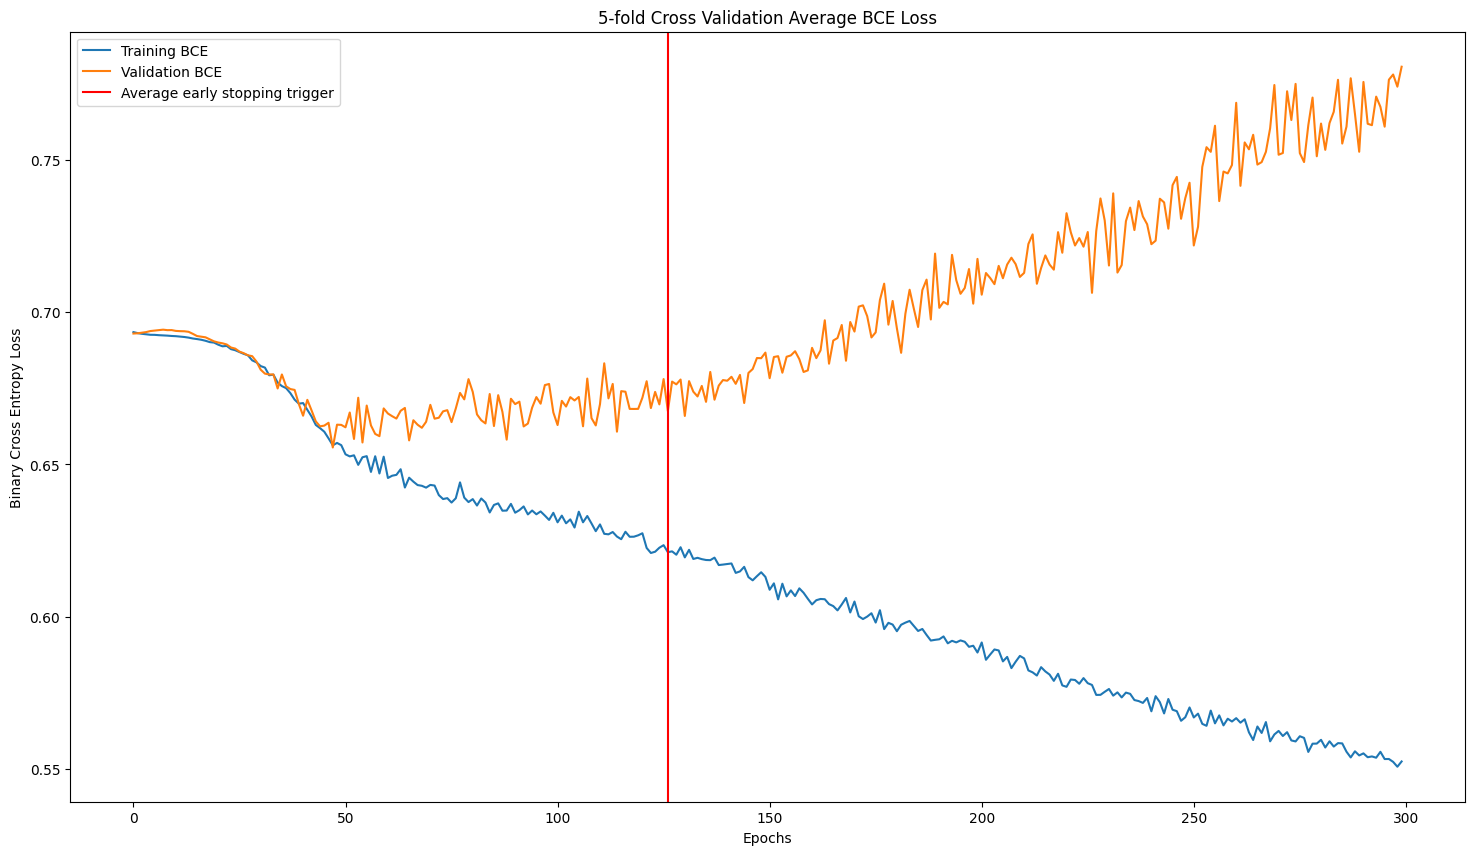

In [ ]:
import matplotlib.pyplot as plt

avg_costs = np.average(costs, axis=0)
avg_test_costs = np.average(test_costs, axis=0)

# avg_costs = costs[4]
# avg_test_costs = test_costs[4]

plt.plot(avg_costs, label = "Training BCE")
plt.plot(avg_test_costs, label = "Validation BCE")
plt.axvline(x = 126, color = 'r', label = 'Average early stopping trigger')

plt.rcParams["figure.figsize"] = (18, 10)
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("5-fold Cross Validation Average BCE Loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
k_fold_positions = [ np.zeros((test_counts[fold], num_outputs)) for fold in range(k_folds) ]

for fold, (train_idx, test_idx) in enumerate(kf.split(data_list)):
  test_features = [node_features[i] for i in test_idx]
  test_targets = [targets[i] for i in test_idx]

  test_dataset = StaticGraphTemporalSignal(edge_index=edge_indices, edge_weight=edge_weights,
                                       features=test_features, targets=test_targets)
  index = 0
  model = models[fold]

  for time, snapshot in enumerate(test_dataset):
      snapshot = snapshot.to(device)
      y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix).cpu().detach().numpy().T
      k_fold_positions[fold][time] = (y_hat > 0.5)
      k_fold_positions[fold][time] = k_fold_positions[fold][time] * 2 - 1

  print(f"Fold {fold+1}: ")
  print(k_fold_positions[fold][k_fold_positions[fold] < 0].sum())
  print(k_fold_positions[fold][k_fold_positions[fold] > 0].sum())

In [ ]:
k_fold_daily_positions = [ np.repeat(k_fold_positions[i], repeats=period, axis=0) for i in range(len(k_fold_positions)) ]

len(k_fold_daily_positions), k_fold_daily_positions[0].shape

In [ ]:
returns = pd.read_csv("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/all_log_returns.csv")
returns = returns.drop("Date", axis=1)
total_days = returns.shape[0]
returns = returns.set_axis(TICKERS, axis=1)
selected_returns = returns[eval_tickers]

start_index = (test_indices[0][0]+window)*period
end_index = (test_indices[k_folds-1][-1]+window)*period+period-1 # inclusive

selected_returns = selected_returns.loc[start_index:end_index]

In [ ]:
# selected_returns

In [ ]:
k_fold_selected_positions = [ pd.DataFrame(k_fold_daily_positions[fold], columns=eval_tickers) for fold in range(k_folds) ]

for fold in range(k_folds):
  k_fold_selected_positions[fold].index = k_fold_selected_positions[fold].index + int((test_indices[fold][0] + window) * period)

In [ ]:
selected_positions = k_fold_selected_positions[0]

for fold in range(1, k_folds):
  selected_positions = selected_positions.append(k_fold_selected_positions[fold])

In [ ]:
selected_positions

In [ ]:
print("Baseline daily accuracy")
for t in eval_tickers:
  bl = (np.sign(selected_returns[t]) == 1).values.sum() / selected_returns.shape[0]
  print(f"{t} daily baseline accuracy: {round(bl * 100, 2)}%")

print("")

print("K-fold model daily accuracy")
for t in eval_tickers:
  avg_acc = 0

  avg_acc = (selected_positions[t] == np.sign(selected_returns[t])).values.sum() / selected_returns.shape[0]

  print(f"{t} model accuracy: {round(avg_acc * 100, 2)}%")

In [ ]:
# Single portfolio
portfolio_positions = selected_positions / num_outputs

model_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * portfolio_positions, axis=1)
cum_model_portfolio_returns = np.exp(np.log(model_portfolio_returns+1).cumsum())
model_portfolio_annual_returns = (np.power(cum_model_portfolio_returns.loc[end_index], 1/24) - 1)
model_portfolio_annual_std = np.exp(model_portfolio_returns).std() * pow(252, 1/2)
model_portfolio_sharpe = model_portfolio_annual_returns / model_portfolio_annual_std

uniform_positions = pd.DataFrame(np.ones((selected_positions.shape[0], 7)) / 7, columns=eval_tickers)

baseline_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * uniform_positions, axis=1)
cum_baseline_portfolio_returns = np.exp(np.log(baseline_portfolio_returns+1).cumsum())
baseline_portfolio_annual_returns = (np.power(cum_baseline_portfolio_returns.loc[end_index], 1/24) - 1)
baseline_portfolio_annual_std = np.exp(baseline_portfolio_returns).std() * pow(252, 1/2)
baseline_portfolio_sharpe = baseline_portfolio_annual_returns / baseline_portfolio_annual_std

In [ ]:
print(f"Baseline portfolio annual return: {round(baseline_portfolio_annual_returns*100, 2)}%")
print(f"Baseline portfolio sharpe ratio: {round(baseline_portfolio_sharpe, 2)}")
print("")
print(f"Model portfolio annual return: {round(model_portfolio_annual_returns*100, 2)}%")
print(f"Model portfolio sharpe ratio: {round(model_portfolio_sharpe, 2)}")

In [ ]:
plt.plot(cum_model_portfolio_returns)

# K-fold Evaluation

In [ ]:
def eval(model, fold, is_test=True):
  model.eval()
  bce_loss = nn.BCELoss()
  cost = 0
  d = test_loaders[fold] if is_test else train_loaders[fold]
  count = 0

  for batch in d:
      x, edge_index, edge_attr, y = batch
      x, edge_index, edge_attr, y = x[0].to(device), edge_index[0].to(device), edge_attr[0].to(device), y[0].to(device)
      count += 1
      y_hat = model(x.to(torch.float32), edge_index, edge_attr, adj_matrix)
      cost = cost + bce_loss(y_hat.flatten().to(torch.float32), y.to(torch.float32))

  cost = cost / (count)
  cost = cost.item()
  return cost, count

for i in range(k_folds):
  model = models[i]
  test_bce, test_count = eval(model, i, is_test=True)
  train_bce, train_count = eval(model, i, is_test=False)

  print(f"{i+1} Fold Training BCE: {round(train_bce, 4)}")
  print(f"{i+1} Fold Test BCE: {round(test_bce, 4)}")

In [ ]:
for fold, (train_idx, test_idx) in enumerate(kf.split(data_list)):
    print(f'Fold {fold + 1}')

    # Split data into training and test sets
    train_data = [data_list[i] for i in train_idx]
    test_data = [data_list[i] for i in test_idx]

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    model = models[fold]
    model.eval()

    train_cost = 0

    for data in train_loader:
        optimizer.zero_grad()

        tmp_batch_size = len(data.x)
        out = torch.from_numpy(np.zeros((tmp_batch_size, num_outputs))).to(device)

        for i in range(tmp_batch_size):
          x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
          edge_index = torch.from_numpy(data.edge_index[i]).to(device)
          edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)

          out[i] = model(x, edge_index, edge_attr, adj_matrix)

        y = torch.Tensor(data.y).to(device).to(torch.double)
        loss = bce_loss(out, y)
        train_cost += loss.item()

    train_cost = train_cost / len(train_loader)

    test_loss = 0

    for data in test_loader:
        optimizer.zero_grad()

        tmp_batch_size = len(data.x)
        out = torch.from_numpy(np.zeros((tmp_batch_size, num_outputs))).to(device)

        for i in range(tmp_batch_size):
          x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
          edge_index = torch.from_numpy(data.edge_index[i]).to(device)
          edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)

          out[i] = model(x, edge_index, edge_attr, adj_matrix)

        y = torch.Tensor(data.y).to(device).to(torch.double)
        loss = bce_loss(out, y)
        test_loss += loss.item()

    test_loss = test_loss / len(test_loader)

    print(f"Training BCE: {round(train_cost, 4)}")
    print(f"Test BCE: {round(test_loss, 4)}")


In [ ]:
# test_indices[4]
data_list[240].x

In [ ]:
old = test_dataset[0].x.cpu().detach().numpy()

new = [ data_list[i].x for i in range(len(data_list)) ]

for i in range(len(new)):
  if np.array_equal(old, new[i]):
    print(i)
    break

# 237
test_dataset[0].x, data_list[238].x

In [ ]:
for fold in range(k_folds):
  try:
    costs[fold] = [ costs[fold][i].cpu().detach().numpy() for i in range(len(costs[fold])) ]
    costs[fold] = np.array(costs[fold])
  except:
    pass

  try:
    test_costs[fold] = [ test_costs[fold][i].cpu().detach().numpy() for i in range(len(test_costs[fold])) ]
    test_costs[fold] = np.array(test_costs[fold])
  except:
    pass

In [ ]:
test_costs = [ np.array(test_costs[i]) for i in range(k_folds)]
costs = [ np.array(costs[i]) for i in range(k_folds)]


In [ ]:
# Match length for each folds' cost and stack cost as 2D np array
max_len = max([len(costs[i]) for i in range(k_folds)])

for i in range(k_folds):
  if max_len - costs[i].shape[0] > 0:
    costs[i] = np.concatenate((costs[i], np.repeat(costs[i][-1], max_len - costs[i].shape[0])))

  if max_len - test_costs[i].shape[0] > 0:
    test_costs[i] = np.concatenate((test_costs[i], np.repeat(test_costs[i][-1], max_len - test_costs[i].shape[0])))

costs = np.vstack(costs)
test_costs = np.vstack(test_costs)

costs.shape, test_costs.shape

In [ ]:
import matplotlib.pyplot as plt

avg_costs = np.average(costs, axis=0)
avg_test_costs = np.average(test_costs, axis=0)

# avg_costs = costs[4]
# avg_test_costs = test_costs[4]

plt.plot(avg_costs, label = "Training BCE")
plt.plot(avg_test_costs, label = "Test BCE")

plt.xlabel("Epochs")
plt.ylabel("BCE")
plt.legend(loc="upper right")
plt.show()

In [ ]:
k_fold_positions = [ np.zeros((len(test_loaders[fold]) * batch_size, num_outputs)) for fold in range(k_folds) ]

for fold in range(k_folds):
  index = 0
  model = models[fold]

  for batch in test_loaders[fold]:
    x, edge_index, edge_attr, y = batch
    x, edge_index, edge_attr, y = x.to(device).to(torch.float32), edge_index.to(device), edge_attr.to(device), y.to(device)
    edge_index, edge_attr = edge_index[0], edge_attr[0]

    tmp_batch_size = x.shape[0] if x.dim() == 3 else 1
    out = torch.from_numpy(np.zeros((tmp_batch_size, num_outputs))).to(device)

    for i in range(tmp_batch_size):
      out = model(x[i], edge_index, edge_attr, adj_matrix)
      k_fold_positions[fold][index] = (out.cpu().detach().numpy() > 0.5)
      k_fold_positions[fold][index] = k_fold_positions[fold][index] * 2 - 1
      index += 1

  print(f"Fold {fold+1}: ")
  print(k_fold_positions[fold][k_fold_positions[fold] < 0].sum())
  print(k_fold_positions[fold][k_fold_positions[fold] > 0].sum())

In [ ]:
k_fold_positions = []
test_indices = []


for fold, (train_idx, test_idx) in enumerate(kf.split(data_list)):
    test_data = [data_list[i] for i in test_idx]
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    k_fold_positions.append(np.zeros((len(test_data), num_outputs)))
    test_indices.append(test_idx)

    model = models[i]
    model.eval()
    index = 0

    for data in test_loader:
        optimizer.zero_grad()

        tmp_batch_size = len(data.x)

        for i in range(tmp_batch_size):
          x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
          edge_index = torch.from_numpy(data.edge_index[i]).to(device)
          edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)

          out = model(x, edge_index, edge_attr, adj_matrix)

          k_fold_positions[fold][index] = (out.cpu().detach().numpy() > 0.5)
          k_fold_positions[fold][index] = k_fold_positions[fold][index] * 2 - 1
          index += 1

    print(f"Fold {fold+1}: ")
    print(k_fold_positions[fold][k_fold_positions[fold] < 0].sum())
    print(k_fold_positions[fold][k_fold_positions[fold] > 0].sum())


In [ ]:
k_fold_daily_positions = [ np.repeat(k_fold_positions[i], repeats=period, axis=0) for i in range(len(k_fold_positions)) ]

len(k_fold_daily_positions), k_fold_daily_positions[4].shape

In [ ]:
returns = pd.read_csv("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/all_log_returns.csv")
returns = returns.drop("Date", axis=1)
total_days = returns.shape[0]
returns = returns.set_axis(TICKERS, axis=1)
selected_returns = returns[eval_tickers]

k_fold_selected_returns = [ selected_returns[j[0]*period:j[-1]*period+period] for j in test_indices ]

In [ ]:
k_fold_selected_returns[3]
# test_indices[4].shape

In [ ]:
k_fold_selected_positions = [ pd.DataFrame(k_fold_daily_positions[fold], columns=eval_tickers) for fold in range(k_folds) ]

for fold in range(k_folds):
  k_fold_selected_positions[fold].index = k_fold_selected_positions[fold].index + int(test_indices[fold][0] * period)
  k_fold_selected_positions[fold] = k_fold_selected_positions[fold].loc[~(k_fold_selected_positions[fold]==0).all(axis=1)]

In [ ]:
k_fold_selected_positions[3]

In [ ]:
print("Baseline daily accuracy")
for t in eval_tickers:
  bl = (np.sign(selected_returns[t]) == 1).values.sum() / selected_returns.shape[0]
  print(f"{t} daily baseline accuracy: {round(bl * 100, 2)}%")

print("")

print("K-fold model daily accuracy")
for t in eval_tickers:
  avg_acc = 0

  for fold in range(k_folds):
    avg_acc += (k_fold_selected_positions[fold][t] == np.sign(k_fold_selected_returns[fold][t])).values.sum() / k_fold_selected_returns[fold].shape[0]

  avg_acc /= k_folds

  print(f"{t} model accuracy: {round(avg_acc * 100, 2)}%")

In [ ]:
all_selected_positions = k_fold_selected_positions[0]

for fold in range(1, k_folds):
  all_selected_positions = all_selected_positions.append(k_fold_selected_positions[fold])


In [ ]:
# Single portfolio
portfolio_positions = all_selected_positions / 7

model_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * portfolio_positions, axis=1)
cum_model_portfolio_returns = np.exp(np.log(model_portfolio_returns+1).cumsum())
model_portfolio_annual_returns = (np.power(cum_model_portfolio_returns.loc[6019], 1/24) - 1)
model_portfolio_annual_std = np.exp(model_portfolio_returns).std() * pow(252, 1/2)
model_portfolio_sharpe = model_portfolio_annual_returns / model_portfolio_annual_std

uniform_positions = pd.DataFrame(np.ones((all_selected_positions.shape[0], 7)) / 7, columns=eval_tickers)
uniform_positions.index = uniform_positions.index + int(total_days // period * period - all_selected_positions.shape[0])

baseline_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * uniform_positions, axis=1)
cum_baseline_portfolio_returns = np.exp(np.log(baseline_portfolio_returns+1).cumsum())
baseline_portfolio_annual_returns = (np.power(cum_baseline_portfolio_returns.loc[6019], 1/24) - 1)
baseline_portfolio_annual_std = np.exp(baseline_portfolio_returns).std() * pow(252, 1/2)
baseline_portfolio_sharpe = baseline_portfolio_annual_returns / baseline_portfolio_annual_std

In [ ]:
print(f"Baseline portfolio annual return: {round(baseline_portfolio_annual_returns*100, 2)}%")
print(f"Baseline portfolio sharpe ratio: {round(baseline_portfolio_sharpe, 2)}")
print("")
print(f"Model portfolio annual return: {round(model_portfolio_annual_returns*100, 2)}%")
print(f"Model portfolio sharpe ratio: {round(model_portfolio_sharpe, 2)}")

# Single Fold Evaluation

In [ ]:
model.eval()
bce_loss = nn.BCELoss()
train_bce = 0
train_count = 0

for data in train_loader:
    tmp_batch_size = len(data.x)
    out = torch.from_numpy(np.zeros((tmp_batch_size, num_outputs))).to(device)
    train_count += 1

    for i in range(tmp_batch_size):
        x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
        edge_index = torch.from_numpy(data.edge_index[i]).to(device)
        edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)
        out[i] = model(x, edge_index, edge_attr, adj_matrix)

    y = torch.Tensor(data.y).to(device).to(torch.double)
    train_bce = train_bce + bce_loss(out, y)

train_bce = train_bce / train_count
train_bce = train_bce.item()

test_bce = 0
test_count = 0

for data in test_loader:
    tmp_batch_size = len(data.x)
    out = torch.from_numpy(np.zeros((tmp_batch_size, num_outputs))).to(device)
    test_count += 1

    for i in range(tmp_batch_size):
        x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
        edge_index = torch.from_numpy(data.edge_index[i]).to(device)
        edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)
        out[i] = model(x, edge_index, edge_attr, adj_matrix)

    y = torch.Tensor(data.y).to(device).to(torch.double)
    test_bce = test_bce + bce_loss(out, y)

test_bce = test_bce / test_count
test_bce = test_bce.item()


print(f"Training BCE: {round(train_bce, 4)}")
print(f"Test BCE: {round(test_bce, 4)}")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(costs, label = "Training BCE")
plt.plot(test_costs, label = "Test BCE")

plt.xlabel("Epochs")
plt.ylabel("BCE")
plt.legend(loc="upper right")
plt.show()

In [ ]:
positions = np.zeros((len(test_data), num_outputs))
index = 0

for data in test_loader:
  optimizer.zero_grad()
  tmp_batch_size = len(data.x)

  for i in range(tmp_batch_size):
    x = torch.from_numpy(data.x[i]).to(device).to(torch.float32)
    edge_index = torch.from_numpy(data.edge_index[i]).to(device)
    edge_attr = torch.from_numpy(data.edge_attr[i]).to(device)

    out = model(x, edge_index, edge_attr, adj_matrix)

    positions[index] = (out.cpu().detach().numpy() > 0.5)
    positions[index] = positions[index] * 2 - 1
    index += 1

print(positions[positions < 0].sum())
print(positions[positions > 0].sum())

In [ ]:
daily_positions = np.repeat(positions, repeats=period, axis=0)

daily_positions.shape

In [ ]:
start_index = (test_idx[0] + window) * period
end_index = start_index + daily_positions.shape[0]

selected_positions = pd.DataFrame(daily_positions, columns=eval_tickers)
selected_positions.index = selected_positions.index + start_index

In [ ]:
returns = pd.read_csv("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/all_log_returns.csv")
returns = returns.drop("Date", axis=1)
total_days = returns.shape[0]
returns = returns.set_axis(TICKERS, axis=1)

returns = returns[start_index:end_index]
selected_returns = returns[eval_tickers]

In [ ]:
print("Baseline daily accuracy")
for t in eval_tickers:
  bl = (np.sign(selected_returns[t]) == 1).values.sum() / selected_returns.shape[0]
  print(f"{t} daily baseline accuracy: {round(bl * 100, 2)}%")

print("")

print("Model daily accuracy")
for t in eval_tickers:
  acc = (selected_positions[t] == np.sign(selected_returns[t])).values.sum() / selected_returns.shape[0]
  print(f"{t} model accuracy: {round(acc * 100, 2)}%")

In [ ]:
# Single portfolio
portfolio_positions = selected_positions / num_outputs

model_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * portfolio_positions, axis=1)
cum_model_portfolio_returns = np.exp(np.log(model_portfolio_returns+1).cumsum())
model_portfolio_annual_returns = np.mean(np.log(model_portfolio_returns+1)) * 252
model_portfolio_annual_std = np.exp(model_portfolio_returns).std() * pow(252, 1/2)
model_portfolio_sharpe = model_portfolio_annual_returns / model_portfolio_annual_std

uniform_positions = pd.DataFrame(np.ones((daily_positions.shape[0], num_outputs)) / num_outputs, columns=eval_tickers)
uniform_positions.index = uniform_positions.index + start_index

baseline_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * uniform_positions, axis=1)
cum_baseline_portfolio_returns = np.exp(np.log(baseline_portfolio_returns+1).cumsum())
baseline_portfolio_annual_returns = np.mean(np.log(baseline_portfolio_returns+1)) * 252
baseline_portfolio_annual_std = np.exp(baseline_portfolio_returns).std() * pow(252, 1/2)
baseline_portfolio_sharpe = baseline_portfolio_annual_returns / baseline_portfolio_annual_std

In [ ]:
print(f"Baseline portfolio annual return: {round(baseline_portfolio_annual_returns*100, 2)}%")
print(f"Baseline portfolio sharpe ratio: {round(baseline_portfolio_sharpe, 2)}")
print("")
print(f"Model portfolio annual return: {round(model_portfolio_annual_returns*100, 2)}%")
print(f"Model portfolio sharpe ratio: {round(model_portfolio_sharpe, 2)}")

In [ ]:
model_returns = selected_positions * selected_returns
model_annual_returns = pow(np.exp(model_returns.sum()), 1/5) - 1
model_annual_std = np.exp(model_returns).std() * pow(252, 1/2)
model_sharpe = model_annual_returns / model_annual_std

baseline_returns = selected_returns
baseline_annual_returns = pow(np.exp(baseline_returns.sum()), 1/5) - 1
baseline_annual_std = np.exp(baseline_returns).std() * pow(252, 1/2)
baseline_sharpe = baseline_annual_returns / baseline_annual_std

In [ ]:
print("Baseline annual returns:")

for t in eval_tickers:
  print(f"{t}: {round(baseline_annual_returns[t]*100, 2)}%")

print("")
print("Model annual returns")

for t in eval_tickers:
  print(f"{t}: {round(model_annual_returns[t]*100, 2)}%")

In [ ]:
print("Baseline Sharpe ratio:")

for t in eval_tickers:
  print(f"{t}: {round(baseline_sharpe[t], 2)}")

print("")
print("TGN Model Sharpe ratio")

for t in eval_tickers:
  print(f"{t}: {round(model_sharpe[t], 2)}")

# Normal Evaluation

In [ ]:
model = saved_models[2]

In [ ]:
def eval(is_test=True):
  model.eval()
  bce_loss = nn.BCELoss()
  cost = 0
  d = test_dataset if is_test else train_dataset
  count = 0

  for time, snapshot in enumerate(d):
      count += 1
      snapshot = snapshot.to(device)
      y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
      cost = cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

  cost = cost / (time+1)
  cost = cost.item()
  return cost, count

test_bce, test_count = eval()
train_bce, train_count = eval(is_test=False)

print(f"Training BCE: {round(train_bce, 4)}")
print(f"Test BCE: {round(test_bce, 4)}")

Training BCE: 0.6331
Test BCE: 0.6243


In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(costs, label = "Training BCE")
# plt.plot(test_costs, label = "Test BCE")

# plt.xlabel("Epochs")
# plt.ylabel("BCE")
# plt.legend(loc="upper right")
# plt.show()

In [ ]:
positions = np.zeros((test_count, num_outputs))
correct = np.zeros(num_outputs)
total = 0

for time, snapshot in enumerate(test_dataset):
    snapshot = snapshot.to(device)
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix).cpu().detach().numpy().T
    positions[time] = (y_hat > 0.5)
    positions[time] = positions[time] * 2 - 1

    tmp_pred = (y_hat > 0.5)
    tmp_true = (snapshot.y == 1).cpu().detach().numpy()

    correct += np.array((tmp_pred == tmp_true))
    total += 1



print(positions[positions < 0].sum())
print(positions[positions > 0].sum())

for c in correct:
  print(f"{round(c/total*100, 2)}%")

-274.0
266.0
55.0%
76.67%
48.33%
60.0%
71.67%
60.0%
61.67%
71.67%
65.0%


In [ ]:
tmp_positions = np.random.randint(2, size=(test_count, num_outputs))

positions = tmp_positions

In [ ]:
daily_positions = np.repeat(positions, repeats=period, axis=0)

daily_positions.shape

(1200, 9)

In [ ]:
train_count

238

In [ ]:
start_index = (train_count + window) * period # (test_idx[0] + window) * period
end_index = min(start_index + daily_positions.shape[0], 6037)

selected_positions = pd.DataFrame(daily_positions, columns=eval_tickers)
selected_positions.index = selected_positions.index + start_index

selected_positions = selected_positions[selected_positions.index < 6037]

In [ ]:
returns = pd.read_csv("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/all_log_returns.csv")
returns = returns.drop("Date", axis=1)
total_days = returns.shape[0]
returns = returns.set_axis(TICKERS, axis=1)

returns = returns[start_index:end_index]
selected_returns = returns[eval_tickers]

In [ ]:
# selected_returns

In [ ]:
print("Baseline daily accuracy")
for t in eval_tickers:
  bl = (np.sign(selected_returns[t]) == 1).values.sum() / selected_returns.shape[0]
  print(f"{t} daily baseline accuracy: {round(bl * 100, 2)}%")

print("")

print("Model daily accuracy")
for t in eval_tickers:
  acc = (selected_positions[t] == np.sign(selected_returns[t])).values.sum() / selected_returns.shape[0]
  print(f"{t} model accuracy: {round(acc * 100, 2)}%")

print("Model daily accuracy")
for t in eval_tickers:
  acc = (selected_positions[t] == np.sign(selected_returns[t])).values.sum() / selected_returns.shape[0]
  print(f"{round(acc * 100, 2)}%")

Baseline daily accuracy
AMD daily baseline accuracy: 50.42%
MMM daily baseline accuracy: 49.25%
MSFT daily baseline accuracy: 53.75%
CME daily baseline accuracy: 52.08%
ABT daily baseline accuracy: 52.08%
CL daily baseline accuracy: 52.58%
CVS daily baseline accuracy: 50.75%
F daily baseline accuracy: 48.67%
IBM daily baseline accuracy: 53.17%

Model daily accuracy
AMD model accuracy: 23.5%
MMM model accuracy: 23.08%
MSFT model accuracy: 26.58%
CME model accuracy: 31.33%
ABT model accuracy: 30.08%
CL model accuracy: 25.58%
CVS model accuracy: 20.92%
F model accuracy: 26.67%
IBM model accuracy: 27.67%
Model daily accuracy
23.5%
23.08%
26.58%
31.33%
30.08%
25.58%
20.92%
26.67%
27.67%


In [ ]:
# Single portfolio
approx_years = 5

portfolio_positions = selected_positions / num_outputs

model_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * portfolio_positions, axis=1)
cum_model_portfolio_returns = np.exp(np.log(model_portfolio_returns+1).cumsum())
# model_portfolio_annual_returns = np.mean(np.log(model_portfolio_returns+1)) * 252
model_portfolio_annual_returns = np.exp(np.mean(np.log(model_portfolio_returns+1)) * 252) - 1
# model_portfolio_annual_std = np.exp(model_portfolio_returns).std() * pow(252, 1/2)
model_portfolio_annual_std = model_portfolio_returns.std() * pow(252, 1/2)
model_portfolio_sharpe = model_portfolio_annual_returns / model_portfolio_annual_std

uniform_positions = pd.DataFrame(np.ones((daily_positions.shape[0], num_outputs)) / num_outputs, columns=eval_tickers)
uniform_positions.index = uniform_positions.index + start_index

baseline_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * uniform_positions, axis=1)
cum_baseline_portfolio_returns = np.exp(np.log(baseline_portfolio_returns+1).cumsum())
# baseline_portfolio_annual_returns = (np.power(cum_baseline_portfolio_returns.loc[end_index-1], 1/approx_years) - 1)
# baseline_portfolio_annual_returns = np.mean(np.log(baseline_portfolio_returns+1)) * 252
baseline_portfolio_annual_returns = np.exp(np.mean(np.log(baseline_portfolio_returns+1)) * 252) - 1
# baseline_portfolio_annual_std = np.exp(baseline_portfolio_returns).std() * pow(252, 1/2)
baseline_portfolio_annual_std = baseline_portfolio_returns.std() * pow(252, 1/2)
baseline_portfolio_sharpe = baseline_portfolio_annual_returns / baseline_portfolio_annual_std

In [ ]:
print(f"Baseline portfolio annual return: {round(baseline_portfolio_annual_returns*100, 2)}%")
print(f"Baseline portfolio sharpe ratio: {round(baseline_portfolio_sharpe, 2)}")
print("")
print(f"Model portfolio annual return: {round(model_portfolio_annual_returns*100, 2)}%")
print(f"Model portfolio sharpe ratio: {round(model_portfolio_sharpe, 2)}")

Baseline portfolio annual return: 14.51%
Baseline portfolio sharpe ratio: 0.67

Model portfolio annual return: 11.26%
Model portfolio sharpe ratio: 0.91


In [ ]:
model_returns = selected_positions * selected_returns
model_annual_returns = pow(np.exp(model_returns.sum()), 1/5) - 1
model_annual_std = np.exp(model_returns).std() * pow(252, 1/2)
model_sharpe = model_annual_returns / model_annual_std

baseline_returns = selected_returns
baseline_annual_returns = pow(np.exp(baseline_returns.sum()), 1/5) - 1
baseline_annual_std = np.exp(baseline_returns).std() * pow(252, 1/2)
baseline_sharpe = baseline_annual_returns / baseline_annual_std

In [ ]:
print("Baseline annual returns:")

for t in eval_tickers:
  print(f"{t}: {round(baseline_annual_returns[t]*100, 2)}%")

print("")
print("Model annual returns")

for t in eval_tickers:
  print(f"{t}: {round(model_annual_returns[t]*100, 2)}%")

Baseline annual returns:
AMD: 37.97%
MMM: -9.86%
MSFT: 28.26%
CME: 6.9%
ABT: 7.52%
CL: 5.69%
CVS: 6.97%
F: 8.07%
IBM: 8.88%

Model annual returns
AMD: 41.99%
MMM: 14.15%
MSFT: 15.76%
CME: 3.11%
ABT: 22.7%
CL: 7.43%
CVS: 22.27%
F: 22.84%
IBM: 34.94%


In [ ]:
print("Baseline Sharpe ratio:")

for t in eval_tickers:
  print(f"{t}: {round(baseline_sharpe[t], 2)}")

print("")
print("TGN Model Sharpe ratio")

for t in eval_tickers:
  print(f"{t}: {round(model_sharpe[t], 2)}")

Baseline Sharpe ratio:
AMD: 0.72
MMM: -0.35
MSFT: 0.92
CME: 0.24
ABT: 0.28
CL: 0.27
CVS: 0.25
F: 0.19
IBM: 0.34

TGN Model Sharpe ratio
AMD: 0.8
MMM: 0.5
MSFT: 0.51
CME: 0.11
ABT: 0.85
CL: 0.35
CVS: 0.79
F: 0.52
IBM: 1.31


# Parameter Tuning

In [ ]:
from torch_geometric_temporal.signal import temporal_signal_split

In [ ]:
all_edge_modes = ["precision"] # ["correlation", "dtw", "precision"]
windows = [3] # [3, 6, 9]
models = []

for mode in all_edge_modes:
  for w in windows:
    for i in range(5):
      print(f"edge_mode = {mode}, window = {w}, run = {i+1}")

      # Start
      edge_mode = mode
      period = 20
      window = w
      mul = 1
      self_edge = 1

      dataset = build_graph_dataset(edge_mode=edge_mode, period=period, window=window, mul=mul)

      # Adj matrix
      adj_matrix = np.zeros((num_nodes, num_nodes))
      edge_indices, _ = get_edge_dict(mode=edge_mode, std=mul)

      for i in range(edge_indices.shape[1]):
        adj_matrix[edge_indices[0, i]][edge_indices[1, i]] = 1

      for j in range(num_nodes):
        adj_matrix[j][j] = self_edge

      adj_matrix = torch.from_numpy(adj_matrix).to(device)

      # Training
      train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

      model = GNNPool(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes)
      # model = DiffPool(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes)
      # model = TechPool(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes, p_1=p_1, p_2=p_2)
      # model = EncoderDecoder_2(hidden_nodes=32, num_features=dataset[0].num_features, num_nodes=dataset[0].num_nodes, p_1=p_1, p_2=p_2)

      model.cuda()

      optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # 0.0005
      costs = []
      test_costs = []

      def train_model_bce():
        model.train()
        bce_loss = nn.BCELoss()
        epochs = 500
        lowest = 100
        patience = 100
        patience_reset = 50

        for epoch in tqdm(range(epochs)):
            cost = 0
            test_cost = 0
            for time, snapshot in enumerate(train_dataset):
                # Train with BCE
                snapshot = snapshot.to(device)
                y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
                cost = cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

            cost = cost / (time+1)
            costs.append(cost.item())
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()

            for time, snapshot in enumerate(test_dataset):
                snapshot = snapshot.to(device)
                y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
                test_cost = test_cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

            test_cost = test_cost / (time + 1)
            test_costs.append(test_cost.item())

            if test_cost < lowest:
              lowest = test_cost
              patience = max(patience, patience_reset)
            else:
              patience -= 1

              if patience == 0:
                print(f"early stopping triggered at {epoch} epochs")
                break

      train_model_bce()

      models.append(model)

      # Evaluation
      def eval(is_test=True):
        model.eval()
        bce_loss = nn.BCELoss()
        cost = 0
        d = test_dataset if is_test else train_dataset
        count = 0

        for time, snapshot in enumerate(d):
            count += 1
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix)
            cost = cost + bce_loss(y_hat.flatten().to(torch.float32), snapshot.y.to(torch.float32))

        cost = cost / (time+1)
        cost = cost.item()
        return cost, count

      test_bce, test_count = eval()
      train_bce, train_count = eval(is_test=False)

      print(f"Training BCE: {round(train_bce, 4)}")
      print(f"Test BCE: {round(test_bce, 4)}")

      positions = np.zeros((test_count, num_outputs))

      for time, snapshot in enumerate(test_dataset):
          snapshot = snapshot.to(device)
          y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, adj_matrix).cpu().detach().numpy().T
          positions[time] = (y_hat > 0.5)
          positions[time] = positions[time] * 2 - 1

      daily_positions = np.repeat(positions, repeats=period, axis=0)

      start_index = (train_count + window) * period # (test_idx[0] + window) * period
      end_index = min(start_index + daily_positions.shape[0], 6037)

      selected_positions = pd.DataFrame(daily_positions, columns=eval_tickers)
      selected_positions.index = selected_positions.index + start_index

      selected_positions = selected_positions[selected_positions.index < 6037]

      returns = pd.read_csv("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/all_log_returns.csv")
      returns = returns.drop("Date", axis=1)
      total_days = returns.shape[0]
      returns = returns.set_axis(TICKERS, axis=1)

      returns = returns[start_index:end_index]
      selected_returns = returns[eval_tickers]

      print("Model daily accuracy")
      for t in eval_tickers:
        acc = (selected_positions[t] == np.sign(selected_returns[t])).values.sum() / selected_returns.shape[0]
        # print(f"{t} model accuracy: {round(acc * 100, 2)}%")
        print(f"{round(acc * 100, 2)}%")

      approx_years = 5

      portfolio_positions = selected_positions / num_outputs

      model_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * portfolio_positions, axis=1)
      cum_model_portfolio_returns = np.exp(np.log(model_portfolio_returns+1).cumsum())
      model_portfolio_annual_returns = np.exp(np.mean(np.log(model_portfolio_returns+1)) * 252) - 1
      model_portfolio_annual_std = model_portfolio_returns.std() * pow(252, 1/2)
      model_portfolio_sharpe = model_portfolio_annual_returns / model_portfolio_annual_std

      uniform_positions = pd.DataFrame(np.ones((daily_positions.shape[0], num_outputs)) / num_outputs, columns=eval_tickers)
      uniform_positions.index = uniform_positions.index + start_index

      baseline_portfolio_returns = np.sum((np.exp(selected_returns) - 1) * uniform_positions, axis=1)
      cum_baseline_portfolio_returns = np.exp(np.log(baseline_portfolio_returns+1).cumsum())
      baseline_portfolio_annual_returns = np.exp(np.mean(np.log(baseline_portfolio_returns+1)) * 252) - 1
      baseline_portfolio_annual_std = baseline_portfolio_returns.std() * pow(252, 1/2)
      baseline_portfolio_sharpe = baseline_portfolio_annual_returns / baseline_portfolio_annual_std

      print(f"Model portfolio annual return: {round(model_portfolio_annual_returns*100, 2)}%")
      print(f"Model portfolio sharpe ratio: {round(model_portfolio_sharpe, 2)}")

edge_mode = precision, window = 3, run = 1


 27%|██▋       | 136/500 [10:37<28:25,  4.68s/it]

early stopping triggered at 136 epochs


Training BCE: 0.6211
Test BCE: 0.6369
Model daily accuracy
52.08%
51.67%
51.0%
48.67%
51.08%
50.83%
51.83%
50.33%
53.17%
Model portfolio annual return: 25.44%
Model portfolio sharpe ratio: 1.21
edge_mode = precision, window = 3, run = 2


 29%|██▉       | 144/500 [11:08<27:33,  4.65s/it]

early stopping triggered at 144 epochs


Training BCE: 0.6331
Test BCE: 0.6243
Model daily accuracy
51.42%
50.58%
49.17%
49.0%
50.75%
50.08%
50.75%
48.92%
52.5%
Model portfolio annual return: 18.69%
Model portfolio sharpe ratio: 0.91
edge_mode = precision, window = 3, run = 3


 28%|██▊       | 138/500 [10:48<28:20,  4.70s/it]

early stopping triggered at 138 epochs


Training BCE: 0.6161
Test BCE: 0.634
Model daily accuracy
51.75%
51.33%
50.17%
49.42%
50.92%
50.0%
51.92%
49.5%
52.33%
Model portfolio annual return: 22.38%
Model portfolio sharpe ratio: 1.05
edge_mode = precision, window = 3, run = 4


 31%|███       | 153/500 [11:52<26:56,  4.66s/it]

early stopping triggered at 153 epochs


Training BCE: 0.6333
Test BCE: 0.6321
Model daily accuracy
52.42%
50.75%
49.67%
48.83%
49.75%
50.08%
49.58%
49.17%
51.67%
Model portfolio annual return: 17.14%
Model portfolio sharpe ratio: 0.81
edge_mode = precision, window = 3, run = 5


  2%|▏         | 10/500 [00:47<38:23,  4.70s/it]


KeyboardInterrupt: 

In [ ]:
# model_name = "sag_pool"
# period = 20
# window = 3
# edge_mode = "precision"
# mul = 1
# save_model = models[3]

# save_path = f"/content/drive/MyDrive/School/Imperial/Year 4/FYP/final_saved_model/{model_name}_edge={edge_mode}_period={period}_window={window}_mul={mul}.pt"

# torch.save(model, save_path)
# print(save_path.split("/")[-1].split(".")[0])

sag_pool_edge=precision_period=20_window=3_mul=1


# Graphing

In [ ]:
# saved_models = []

# Data 2, encoder decoder
# Data 2, CapPool

In [ ]:
saved_models.append(models[1])
# saved_models[2] = models[3]

In [ ]:
# saved_models

In [ ]:
min_var_cum_returns = pd.read_csv("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/min_var_cum_returns.csv", names=["Index", "Cum_Returns"])
min_var_cum_returns = min_var_cum_returns.drop(["Index"], axis=1)
min_var_cum_returns.index = min_var_cum_returns.index + 4530

min_var_cum_returns = min_var_cum_returns.loc[start_index:end_index-1]

min_var_cum_returns

In [ ]:
# cap_pool_cum_returns = cum_model_portfolio_returns
# baseline_cum_returns = cum_baseline_portfolio_returns
# encoder_decoder_cum_returns = cum_model_portfolio_returns
# sag_pool_cum_returns = cum_model_portfolio_returns
random_cum_returns = cum_model_portfolio_returns


In [ ]:
import datetime as dt

df = pd.read_csv("/content/drive/MyDrive/School/Imperial/Year 4/FYP/Data/all_log_returns.csv")
dates = [dt.datetime.strptime(d, "%Y-%m-%d").date() for d in df["Date"]]

dates = dates[start_index:end_index]

len(dates)

1200

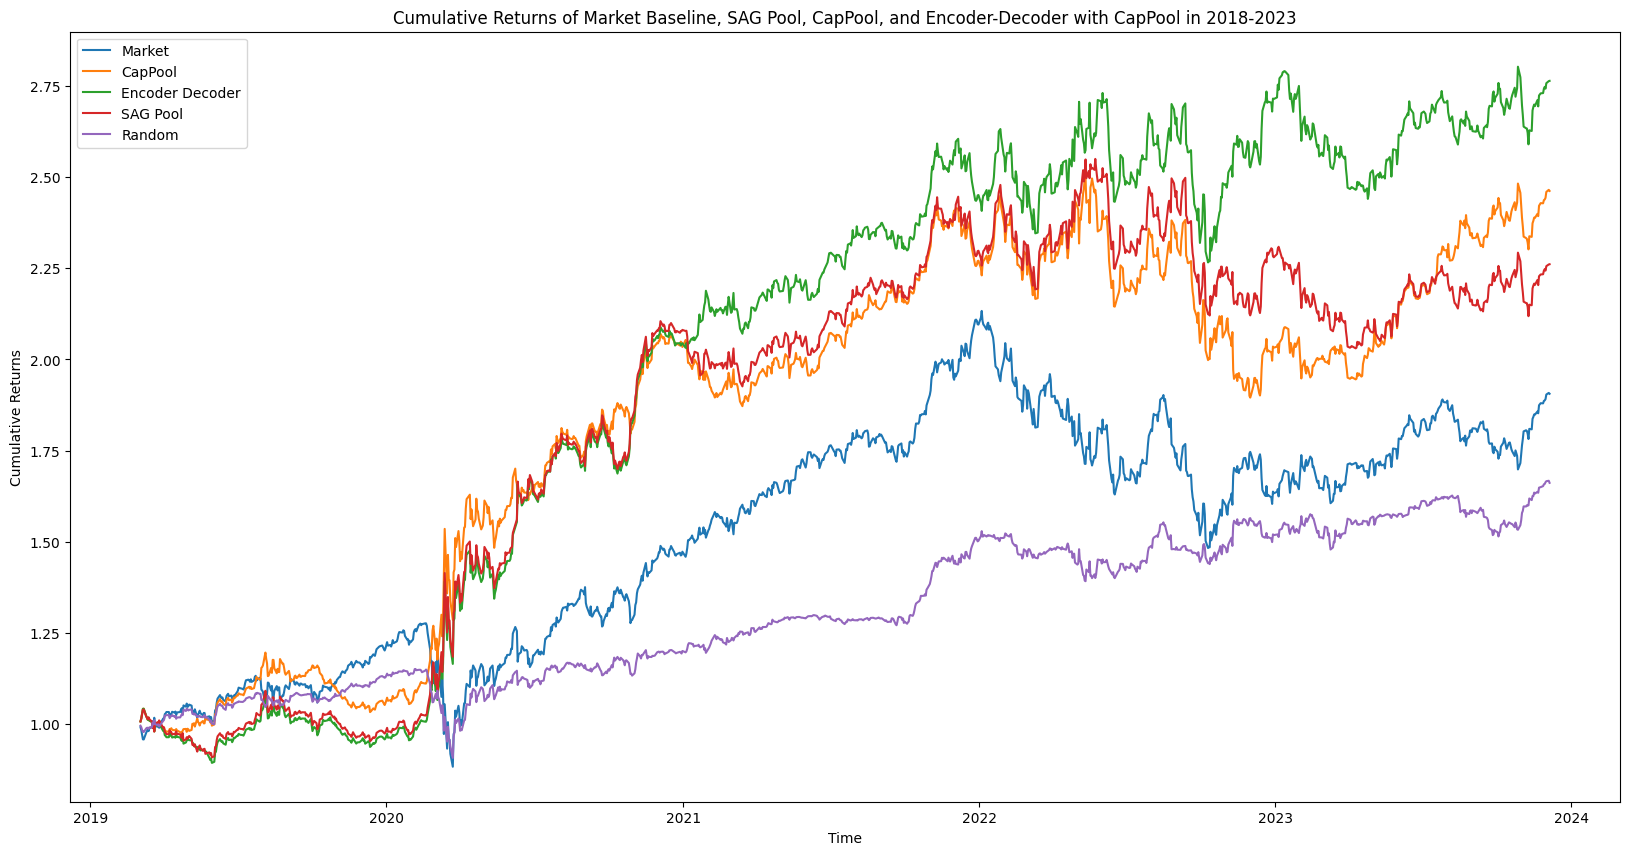

In [ ]:
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(dates, baseline_cum_returns, label="Market")

plt.plot(dates, cap_pool_cum_returns, label="CapPool")
plt.plot(dates, encoder_decoder_cum_returns, label="Encoder Decoder")
plt.plot(dates, sag_pool_cum_returns, label="SAG Pool")
plt.plot(dates, random_cum_returns, label="Random")
plt.legend(loc="upper left")

plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Market Baseline, SAG Pool, CapPool, and Encoder-Decoder with CapPool in 2018-2023")

plt.show()

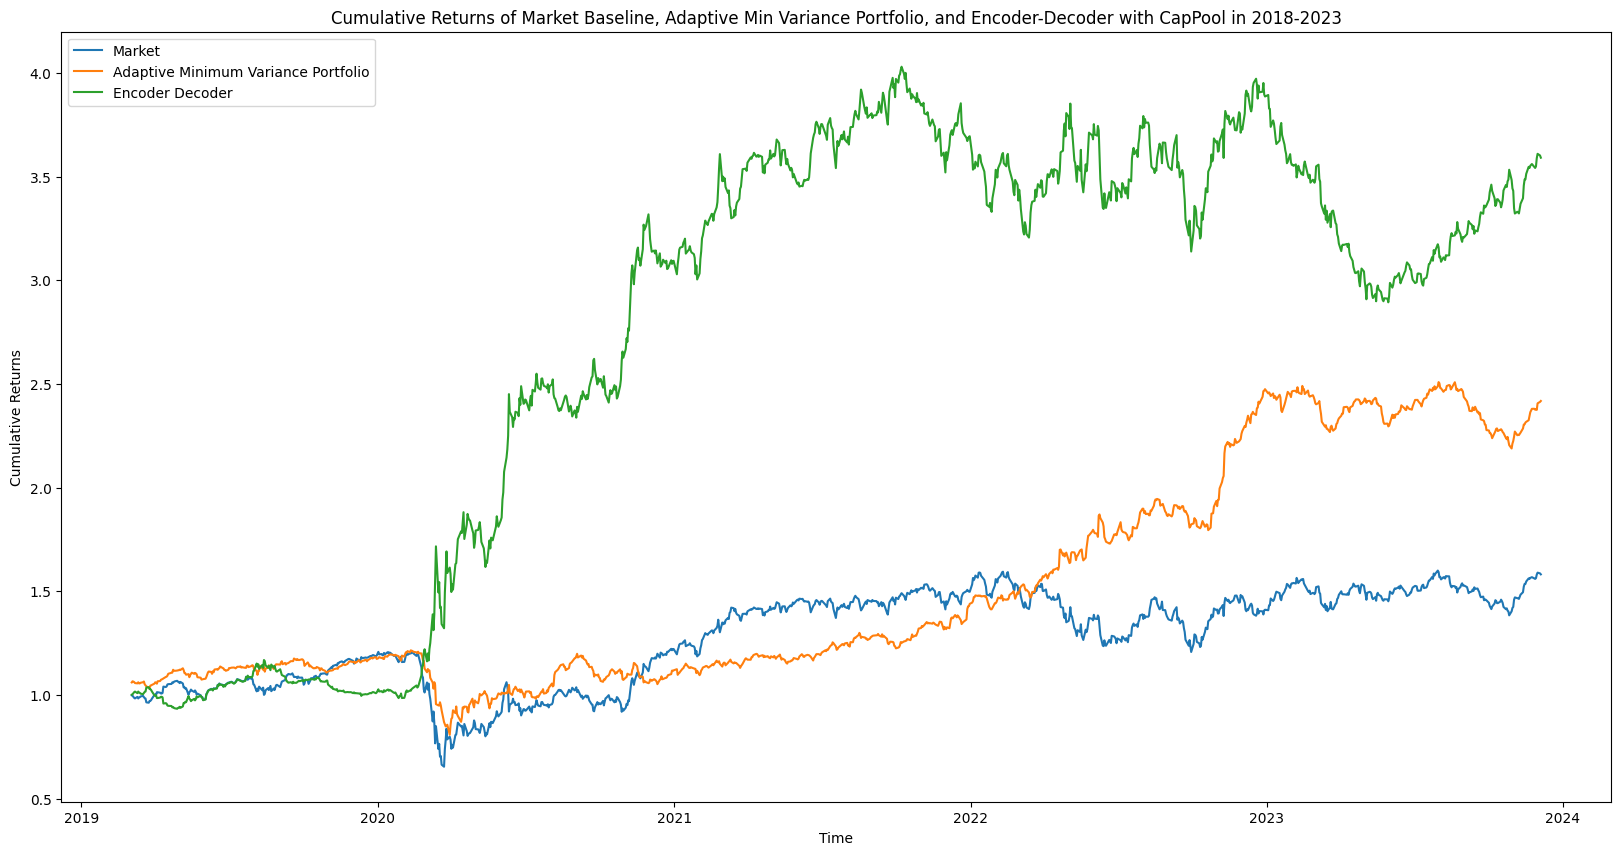

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(dates, baseline_cum_returns, label="Market")

plt.plot(dates, min_var_cum_returns, label="Adaptive Minimum Variance Portfolio")
plt.plot(dates, encoder_decoder_cum_returns, label="Encoder Decoder")
plt.legend(loc="upper left")

plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Market Baseline, Adaptive Min Variance Portfolio, and Encoder-Decoder with CapPool in 2018-2023")

plt.show()

In [ ]:
outputs = get_all_outputs(bin=True, period=20, window=3)

outputs, outputs.shape

(array([[0., 0., 0., ..., 0., 0., 1.],
        [1., 1., 1., ..., 1., 1., 0.],
        [0., 0., 0., ..., 1., 0., 1.],
        ...,
        [0., 1., 1., ..., 0., 1., 1.],
        [1., 1., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 1., 0.]]),
 (298, 7))

In [ ]:
# print(outputs[outputs == 1].sum())
# print(outputs[outputs == 0].sum())

print(np.count_nonzero(outputs == 1, axis=0))
print(np.count_nonzero(outputs == 0, axis=0))

[148 149 146 149 151 156 143]
[150 149 152 149 147 142 155]


# Count Parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
tmp_model = GNNPool(hidden_nodes=32, num_features=3, num_nodes=501)
# tmp_model = TechPool(hidden_nodes=32, num_features=3, num_nodes=501, p_1=p_1, p_2=p_2)
# tmp_model = EncoderDecoder_2(hidden_nodes=32, num_features=3, num_nodes=501, p_1=p_1, p_2=p_2)
# tmp_model = DiffPool(hidden_nodes=32, num_features=3, num_nodes=501)

print(count_parameters(tmp_model))

50669
